In [46]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, GRU, Bidirectional, BatchNormalization, Dropout, CuDNNGRU
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.utils.io_utils import HDF5Matrix
from keras.callbacks import History 
history = History()

model = Sequential()
#define first two bidirectional lstm/gru layer with around 300 neurons
model.add(Bidirectional(CuDNNGRU(300, return_sequences=True), input_shape=(300, 120)))
model.add(Bidirectional(CuDNNGRU(300)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))

#define a fully connected hidden layer with about 300 neurons
model.add(Dense(300))
model.add(Activation('relu'))

#define a output layer with 3 neurons
model.add(Dense(8))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01, decay=0.7),  metrics=['accuracy'])

# Generator section
def data_generator(totalsamples, batchsize = 100):

    number_of_batches = totalsamples/batchsize
    start = 0
    while 1:
        X = HDF5Matrix('E:/nturgbd_skeletons/3Action/traindataset.h5', 'traindata', start, start + batchsize)
        y = HDF5Matrix('E:/nturgbd_skeletons/3Action/traindataset.h5', 'trainlabel', start, start + batchsize)
        start = start + batchsize
        yield (X,y)
        
        #restart counter to yeild data in the next epoch as well
        if start > number_of_batches:
            start = 0

# for layer in model.layers:
#     weights = layer.get_weights() # list of numpy arrays

vtrain = HDF5Matrix('E:/nturgbd_skeletons/3Action/traindataset.h5', 'testdata', 0, 200)
vtarget = HDF5Matrix('E:/nturgbd_skeletons/3Action/traindataset.h5', 'testlabel', 0, 200)

# Early stopping for no progress in validation in loss
# es = EarlyStopping(monitor='val_acc', min_delta=0.1, patience=4, verbose=1, mode='auto')



getdata = data_generator(7200, 100)
model.fit_generator(generator = getdata, steps_per_epoch=72, epochs=30,
                    verbose=2, validation_data=(vtrain, vtarget), shuffle=True, callbacks=[history])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_39 (Bidirectio (None, 300, 600)          759600    
_________________________________________________________________
bidirectional_40 (Bidirectio (None, 600)               1623600   
_________________________________________________________________
batch_normalization_20 (Batc (None, 600)               2400      
_________________________________________________________________
activation_58 (Activation)   (None, 600)               0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 600)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 300)               180300    
_________________________________________________________________
activation_59 (Activation)   (None, 300)               0         
__________

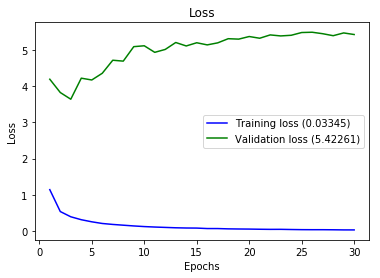

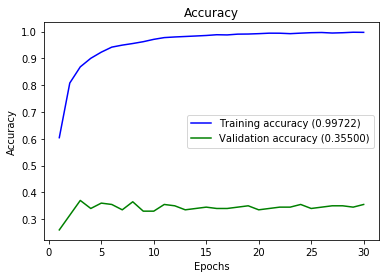

In [47]:
import matplotlib.pyplot as plt
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
plot_history(history)

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from keras.wrappers.scikit_learn import KerasClassifier
import itertools
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
## multiclass or binary report
## If binary (sigmoid output), set binary parameter to True
def full_multiclass_report(model,
                           x,
                           y_true,
                           classes,
                           batch_size=32,
                           binary=False):

    # 1. Transform one-hot encoded y_true into their class number
    if not binary:
        y_true = np.argmax(y_true,axis=1)
    
    # 2. Predict classes and stores in y_pred
    y_pred = model.predict_classes(x, batch_size=batch_size)
    
    # 3. Print accuracy score
    print("Accuracy : "+ str(accuracy_score(y_true,y_pred)))
    
    print("")
    
    # 4. Print classification report
    print("Classification Report")
    print(classification_report(y_true,y_pred,digits=5))    
    
    # 5. Plot confusion matrix
    cnf_matrix = confusion_matrix(y_true,y_pred)
    print(cnf_matrix)
    plot_confusion_matrix(cnf_matrix,classes=classes)

In [50]:
model.save("E:/nturgbd_skeletons/3Action/bs100lr0.01d0.7do0.6acc51.35")

Accuracy : 0.5135135135135135

Classification Report
             precision    recall  f1-score   support

          0    0.00000   0.00000   0.00000         6
          1    1.00000   0.16667   0.28571         6
          2    0.25000   1.00000   0.40000         1
          3    1.00000   0.75000   0.85714         4
          4    0.83333   1.00000   0.90909         5
          5    0.33333   0.60000   0.42857         5
          6    0.20000   1.00000   0.33333         1
          7    0.62500   0.55556   0.58824         9

avg / total    0.59212   0.51351   0.48267        37

[[0 0 0 0 0 3 1 2]
 [0 1 2 0 0 1 2 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 3 1 0 0 0]
 [0 0 0 0 5 0 0 0]
 [0 0 1 0 0 3 0 1]
 [0 0 0 0 0 0 1 0]
 [1 0 0 0 0 2 1 5]]


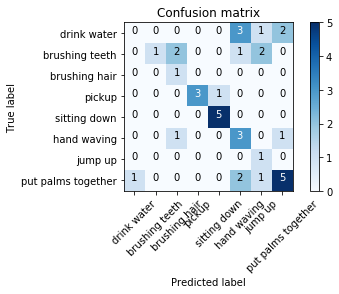

In [49]:
classes = ['drink water','brushing teeth','brushing hair','pickup','sitting down','hand waving','jump up','put palms together']
X = HDF5Matrix('E:/nturgbd_skeletons/3Action/traindataset.h5', 'testdata', 301, 338)
y = HDF5Matrix('E:/nturgbd_skeletons/3Action/traindataset.h5', 'testlabel', 301, 338)

full_multiclass_report(model, X, y, classes)